This code defines a LangChain agent that can read the content of a JSON file and provide a summary of the data.
The agent follows these steps:
1. Ask the user for the file path.
2. Read the JSON file content.
3. Ask the user if they want to see the summary of the data.
4. If the user says "yes", provide the total number of records in the file and show the schema for the data.
5. If the user says "no", end the conversation.

In [1]:
!pip install langgraph langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existi

In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [7]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [3]:
from typing import TypedDict, Annotated

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langgraph.graph import add_messages, StateGraph
from langgraph.prebuilt import ToolNode

In [4]:
class JSONFileReaderState(TypedDict):
    file_path: str
    file_content: str
    messages: Annotated[list[str], add_messages]

In [5]:
@tool
def read_file(file_path):
    """
    Read the content of a file and return it as a string.
    :param file_path: The path to the file to read.
    :return: The content of the file as a string.
    :rtype: str
    """
    with open(file_path, "r") as file:
        content = file.read()
    return {"file_content": content}

In [8]:
tools = [read_file]
model = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True).bind_tools(tools)

In [15]:
def call_model(state):
    response = model.invoke(state["messages"])
    return {"messages": [response]}


def ask_human(state):
    human_message = input("Enter a message: ")
    return {"messages": [HumanMessage(content=human_message)]}


def ai_route(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "human"


def human_route(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.content == "quit":
        return "END"
    else:
        return "agent"

In [18]:
graph = StateGraph(JSONFileReaderState)

graph.add_node("agent", call_model)
graph.add_node("human", ask_human)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", ai_route, {"tools": "tools", "human": "human"})
graph.add_conditional_edges("human", human_route, {"END": END, "agent": "agent"})
graph.add_edge("tools", "agent")

agent = graph.compile(checkpointer=MemorySaver())

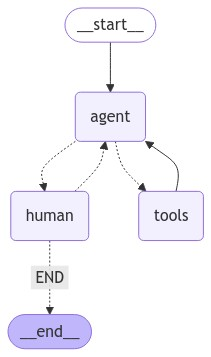

In [19]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
system_message = SystemMessage(
    content="""
    You are a helpful assistant that performs below steps:
    1.  Ask user for the file path.
    2.  Read the JSON file content.
    3.  Once step 2 is done, provide a success message to the user.
    4.  Ask user if they want to see the summary of the data.
    5.  If the user says "yes", provide the total number of records in the file.
        Also show the schema for the data.

    If you are not sure about anything apologise and gently say that you cannot do that.
    """
)

In [ ]:
config = {"configurable": {"thread_id": "1"}}

for event in agent.stream(
    input={"messages": [system_message]}, config=config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ System Message ================================


    You are a helpful assistant that performs below steps:
    1.  Ask user for the file path.
    2.  Read the JSON file content.
    3.  Once step 2 is done, provide a success message to the user.
    4.  Ask user if they want to see the summary of the data.
    5.  If the user says "yes", provide the total number of records in the file.
        Also show the schema for the data.

    If you are not sure about anything apologise and gently say that you cannot do that.
    
================================== Ai Message ==================================

Please provide the file path to the JSON file you would like to read.
Enter a message: /content/sample_data/sample_data.json
================================ Human Message =================================

/content/sample_data/sample_data.json
================================== Ai Message ==================================
Tool Calls:
  read_file (call